In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv("/content/drive/MyDrive/country_data.csv")

In [6]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [9]:
countries=df.country
df.drop("country", axis=1, inplace=True)

#### Standardising the feautures

In [10]:
def zscore_normalise_features(x):
    mu=np.mean(x,axis=0)
    sd=np.std(x,axis=0)
    x_norm=(x-mu)/sd
    return mu,sd,x_norm
mu,sd,df=zscore_normalise_features(df)

In [11]:
df=df.to_numpy()

#### Initialising centroids using K++

In [44]:
def init_centroids(X, k, random_state=123):

    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # Step 1: Choose the first centroid randomly from the data points
    centroids = []
    first_centroid_idx = np.random.randint(n_samples)
    centroids.append(X[first_centroid_idx])

    # Step 2: Select remaining k-1 centroids
    for _ in range(1, k):
        # Compute the squared distances between each point and the nearest centroid
        distances = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)

        # Compute probabilities proportional to the squared distances
        probabilities = distances / np.sum(distances)

        # Choose the next centroid using the computed probabilities
        next_centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids.append(X[next_centroid_idx])

    return np.array(centroids)


In [27]:
def find_closest_centroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        l=X[i]-centroids[0]
        l**=2
        d=np.sum(l)
        min_d=d
        index=0

        for j in range(1,K):
            l=X[i]-centroids[j]
            l**=2
            d=np.sum(l)
            if (d<min_d):
                min_d=d
                index=j
        idx[i]=index
    return idx

In [28]:
def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    for i in range(K):
        total=np.zeros((1,n))
        count=0
        for j in range (m):
            if idx[j]==i:
                total+=X[j]
                count+=1
        total/=count
        centroids[i]=total
    return centroids

In [29]:
def wcss(x, idx, centroids):
    #x is a numpy array
    wcss=0
    m=x.shape[0]
    for i in range(len(x)):
        id=idx[i]
        wcss+=np.sum((x[i]-centroids[id])**2)
    return wcss

In [45]:
def silhouette_score(x, k, idx, centroids):

    m = x.shape[0]
    total_score = 0

    # Loop over each data point
    for i in range(m):
        id = idx[i]

        # Intra-cluster distance (a)
        a = 0
        same_cluster_points = x[idx == id]  # Points in the same cluster
        for point in same_cluster_points:
            a += np.sum((x[i] - point) ** 2)
        a /= len(same_cluster_points)  # Average intra-cluster distance

        # Inter-cluster distance (b)
        b = np.inf  # Start with a very high value for the minimum
        for j in range(k):
            if j != id:
                other_cluster_points = x[idx == j]  # Points in a different cluster
                inter_dist = 0
                for point in other_cluster_points:
                    inter_dist += np.sum((x[i] - point) ** 2)
                inter_dist /= len(other_cluster_points)  # Average inter-cluster distance
                b = min(b, inter_dist)  # Find the nearest cluster

        # Compute silhouette coefficient for this point
        epsilon = 1e-8
        silhouette_coeff = (b - a) / (max(a, b) + epsilon)


        total_score += silhouette_coeff

    # Average silhouette score for all points
    silhouette_score = total_score / m

    return silhouette_score


In [46]:
max_iters=15
def run_kMeans(X, K, max_iters=15, plot_progress=True):
    centroids = init_centroids(X,K)
    m, n = X.shape

    WCSS=[]
    for i in range(max_iters):
        #print("K-Means iteration %d/%d" % (i, max_iters-1))
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
        WCSS.append(wcss(X,idx,centroids))

    return centroids, idx, WCSS



###Finding optimal number of clusters
* elbow method (wcss vs k)
* silhouette score vs k

In [47]:
sil_score=[]
wcss_arr=[]
for i in range(1,11):
    centroids,idx,WCSS=run_kMeans(df,i)
    sil_score.append(silhouette_score(df,i,idx,centroids))
    wcss_arr.append(wcss(df,idx,centroids))

<ipython-input-45-790b59a6b241>:30: RuntimeWarning: invalid value encountered in scalar divide
  silhouette_coeff = (b - a) / (max(a, b) + epsilon)


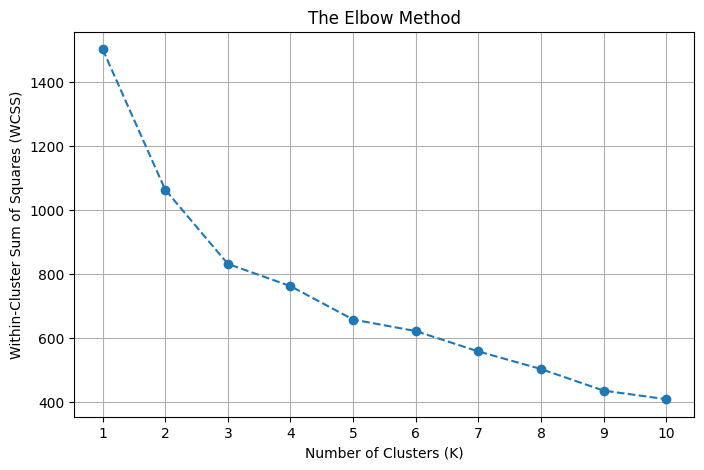

In [48]:
K_range = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss_arr, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

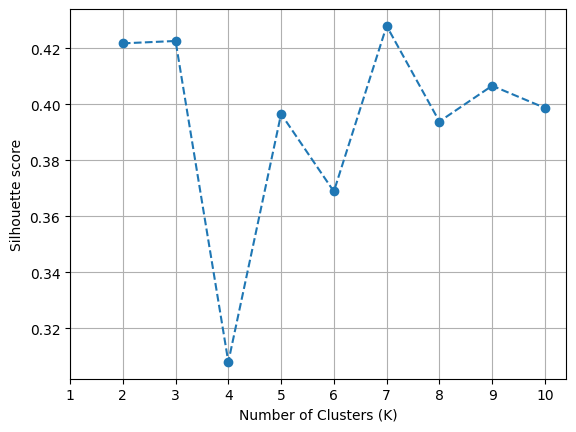

In [49]:
plt.plot(K_range, sil_score, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette score')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [62]:
centroids,idx,WCSS=run_kMeans(df,5)

In [63]:
centroids

array([[ 0.35990636, -0.35505953, -0.68297443, -0.60829418, -0.44721403,
         1.05752144, -0.38908296,  0.34685195, -0.49729057],
       [-0.8460476 , -0.07541763,  1.35374037, -0.40056665,  1.16446894,
        -0.60250762,  1.16127883, -0.76721509,  1.71575306],
       [-0.51632009,  0.14515577, -0.06235265,  0.25849788, -0.1398047 ,
        -0.27012872,  0.35669308, -0.50769876, -0.25926447],
       [ 1.6166161 , -0.56721494,  0.0525775 , -0.06494737, -0.79013112,
        -0.06143629, -1.51212913,  1.55258294, -0.65767158],
       [-0.77926174,  2.63552915, -0.63972027,  1.69438171,  2.85533624,
        -0.12679869,  1.00877524, -0.77880981,  2.03014446]])

In [71]:
from sklearn.metrics import f1_score

In [87]:
y=df['kmeans']
x=df.drop("kmeans", axis=1)

In [121]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test=train_test_split(x,y, train_size=0.8, random_state=42)

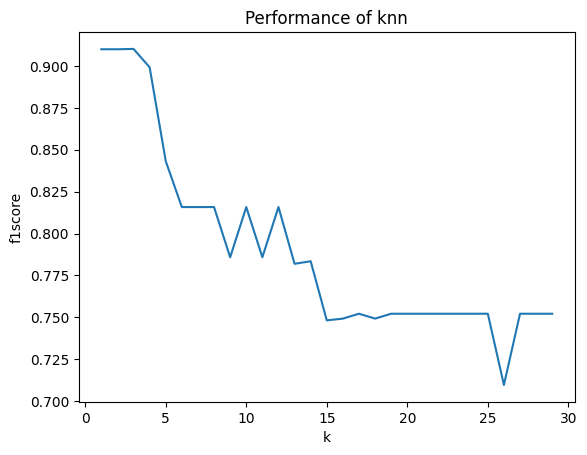

In [144]:
def most_common(lst):
    return max(set(lst), key=lst.count)
def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
      neighbors = []
      for i, x in enumerate(X_test):
        distances = self.dist_metric(x, self.X_train)
        # Sort distances and get corresponding labels
        sorted_labels = [label for _, label in sorted(zip(distances, self.y_train))]
        # Pick top k neighbors
        top_k_neighbors = sorted_labels[:self.k]
        neighbors.append(top_k_neighbors)
      return [most_common(neighbors_list) for neighbors_list in neighbors]


    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(np.array(y_pred) == np.array(y_test)) / len(y_test) # Convert to NumPy arrays for element-wise comparison
        return accuracy

f1_scores= []
accuracies=[]
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(x_train.to_numpy(), y_train.to_numpy())
    y_preds=knn.predict(x_test.to_numpy())
    f1=f1_score(y_test, y_preds,average="weighted")
    accuracy = knn.evaluate(x_test.to_numpy(), y_test.to_numpy())
    accuracies.append(accuracy)
    f1_scores.append(f1)
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, f1_scores)
ax.set(xlabel="k",
       ylabel="f1score",
       title="Performance of knn")
plt.show()

In [145]:
np.argmax(f1_scores)

2

In [146]:
knn = KNeighborsClassifier(k=3)
knn.fit(x_train.to_numpy(), y_train.to_numpy())
y_preds=knn.predict(x_test.to_numpy())
f1=f1_score(y_test, y_preds,average="weighted")
accuracy = knn.evaluate(x_test.to_numpy(), y_test.to_numpy())

In [148]:
f1

0.9101604278074866

In [94]:
y_preds

array([3, 2, 0, 3, 2, 2, 2, 1, 1])